# Driver safety estimation
Pointer Telocation is a developer of telocation devices for cars, focusing on fleet management and MRM (Mobile Resource Management). 
In addition to speed and location, the devices are capable of emitting different events related to driver behavior, such as harsh turns, harsh acceleration and harsh braking.

The objective of this project is to estimate a specific driver's safety score, for various business scenarios. Additional use cases include driver identification, eco-scoring and theft detection by deviation from the routine driver behavior.

## Data understanding and preparation

#### Load packages and set display options for notebook

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn 
import matplotlib.pyplot as plt

## Supress scientific notation
pd.options.display.float_format = '{:.4f}'.format

### Exploratory data analysis
The data represents various events created by the in-car devices. Most of the events are #system_events and some are #behavioral_driver_events.


We will have two different data frames: 

*dfRaw* will contain all event types,

*df* will contain only events relevant for analysis, such as behavioral events (harsh turns, accelerations etc.)


To read the data from file:

In [2]:
## read data from csv
dfRaw = pd.read_csv("dataset.csv",index_col='DriverId')
dfRaw['ts']= pd.to_datetime(dfRaw.ts)
print('Size of dataset: {}'.format(len(dfRaw)))
dfRaw.head(10)

Size of dataset: 899611


,EventName,Latitude,Longitude,Speed km/h,ts
DriverId,,,,,
0,Timed Event,34.1866,-118.0881,64.0000,2017-11-01 00:00:02.430
0,Distance Event,34.1861,-118.0892,53.0000,2017-11-01 00:00:05.600
0,Distance Event,34.1864,-118.0896,34.0000,2017-11-01 00:00:13.640
0,Distance Event,34.1875,-118.0889,33.0000,2017-11-01 00:00:26.070
0,Distance Event,34.1887,-118.0865,32.0000,2017-11-01 00:00:35.090
0,Distance Event,34.1882,-118.0873,47.0000,2017-11-01 00:00:46.330
0,Distance Event,34.1894,-118.0864,24.0000,2017-11-01 00:00:55.320
0,Timed Event,34.1888,-118.0861,35.0000,2017-11-01 00:01:02.770
0,Distance Event,34.1891,-118.0851,43.0000,2017-11-01 00:01:06.610


In [3]:
Driver_Index=np.unique(dfRaw.index.to_numpy())
print("Number of drivers: {}".format(len(Driver_Index)))
Driver_Index.view()

Number of drivers: 89


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88], dtype=int64)

In [4]:
#Event per Driver 

#SQL TYPE
#eventsPerDriver = dfRaw.groupby('DriverId').agg({"EventName":"count"}).add_suffix('_count')

#KASIF TYPE
EventPerDriver=dfRaw.groupby("DriverId").size().to_dict()
print("Mean number of events per driver {:0.1f}".format(   np.mean(list(EventPerDriver.values()))    )) 
dfEventPerDriver=pd.DataFrame(EventPerDriver.items(),columns=("DriverID","NumEvents"))
dfEventPerDriver.head(3)

Mean number of events per driver 10108.0


,DriverID,NumEvents
0,0,17345
1,1,20694
2,2,11945


Text(0, 0.5, 'Number of drivers')

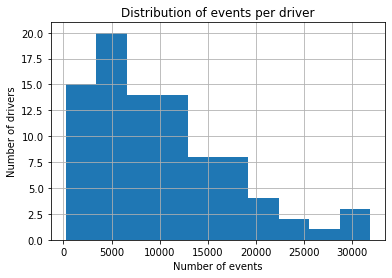

In [5]:
#Distribution of events per driver 
dfEventPerDriver.sort_values(by='NumEvents',ascending = False,inplace = True)

eventsHist = dfEventPerDriver['NumEvents'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

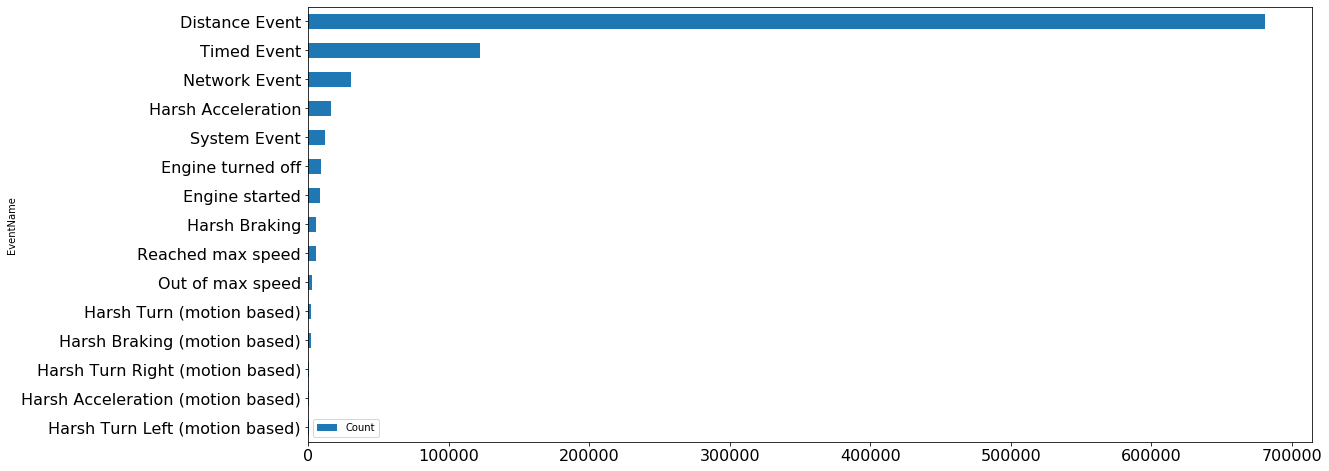

In [6]:
#Event Type Distribution
#SQL Type
#dfReasonHist = dfRaw.groupby(['EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
#Kasif Type
Event_Hist=pd.DataFrame(dfRaw.groupby(['EventName']).size().to_dict().items(),columns=['EventName','Count']).sort_values("Count",ascending=True)
Event_Hist
Event_Hist.plot.barh('EventName','Count',figsize=(18,8),fontsize = 16)

Removing the Distance, Timed and Network events results in much less events:

In [7]:
event=list(dfRaw.groupby("EventName").size().to_dict().keys())
event.remove('Distance Event')
event.remove('Timed Event')
event.remove('Network Event')

In [8]:
dfEvent=dfRaw[dfRaw.EventName.isin(event)]
print("Number of events before removing Distance Event, Timed Event, Network Event: {}\nNumber of current event : {}".format(len(dfRaw),len(dfEvent)))

Number of events before removing Distance Event, Timed Event, Network Event: 899611
Number of current event : 66010


In [9]:
RELEVANT_EVENTS = ['Harsh Acceleration' ,'Reached max speed'   , 'Out of max speed',          'Harsh Braking' ,
        'Harsh Turn (motion based)'     ,'Harsh Braking (motion based)'  , 'Harsh Acceleration (motion based)',
        'Harsh Turn Left (motion based)','Harsh Turn Right (motion based)']


def prepData(dfRaw, minRecordsPerSubscriber = 50):
    dfRaw.reset_index(inplace=True)
    print("*** Starting data prep. Length:",len(dfRaw),"***")
  
    
    #Remove NAs
    dfRaw = dfRaw.dropna()
    print("Removed NAs. Length:",len(dfRaw))

    ## Filter out unwanted events
    df = dfRaw[dfRaw.EventName.isin(RELEVANT_EVENTS)]
    print("Keeping only events that are relevant for modeling. Length:",len(df))
    
    
    ## Filter out users with too few samples
    eventCountPerDriver = df.groupby('DriverId')['DriverId'].agg('count')
    driversWithManyRecords = eventCountPerDriver[eventCountPerDriver > minRecordsPerSubscriber]
    driversWithManyRecords.keys()
    df = df[df.DriverId.isin(driversWithManyRecords.keys())]
    print("Filtering users with too few samples. Length:",len(df))

    print("*** Done. ***")
    return(df)

df = prepData(dfRaw)


*** Starting data prep. Length: 899611 ***
Removed NAs. Length: 899611
Keeping only events that are relevant for modeling. Length: 36468
Filtering users with too few samples. Length: 36262
*** Done. ***


#### Distribution of events per subscriber, while removing functional (non-behavioral) events

Text(0, 0.5, 'Number of drivers')

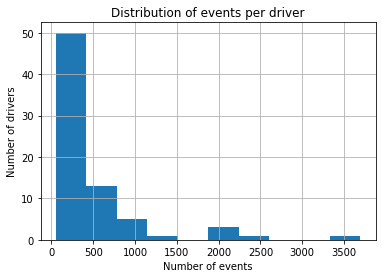

In [10]:
relevantEventsPerSubscriber = df.groupby('DriverId').agg({"EventName":"count"}).sort_values(by='EventName',ascending = False)

eventsHist = relevantEventsPerSubscriber['EventName'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

Types of events:

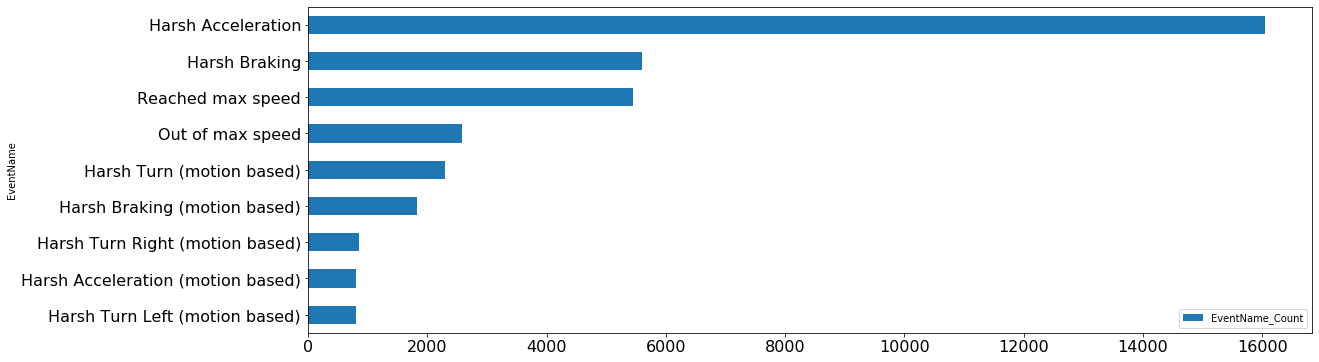

In [11]:
dfReasonHist = df.groupby('EventName')[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(18,6),fontsize = 16)

Some insights from this chart:
1. The number of high speed start events != number of events of end of high speed, which raises a red flag. In addition, the calculation could be inaccurate since it compares the current driver speed with a constant (e.g. 120 km/h) and not to the actual speed limit, so we will not be using it. The correct approach is to use an API that provides road segment max speed, and compare the driver's speed to the max speed. These APIs also have the option of snap-to-road which eliminated errors due to inaccurate GPS readings. For more info, see here: https://www.microsoft.com/en-us/maps/snap-to-road

2. There are multiple events that represent the same thing. For example, 'Harsh Acceleration' and 'Harsh Acceleration (motion based)'. This is due to different versions of the device, or to different sensors installed on different cars.

3. The motion based device has three values for harsh turning: Harsh Turn, Harsh Turn Left and Harsh Turn Right. We can further see that Harsh Turn Left + Harsh Turn Right != Harsh Turn. This is due to the time in which each event type was introduced into the system. We will use Harsh Turn and ignore the left and right values.

Since some drivers have more days of data on the system than others, looking at the absolute number of events isn't accurate. Instead, we'll normalize the number of events per driver by dividing by either total drive time or total distance.

In this code we calculate the total distance each driver had travelled:

In [12]:
## Calculate haversine distance (https://en.wikipedia.org/wiki/Haversine_formula)
## Code taken (and modified) from here: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def total_distance(oneDriver):
    dist = haversine(oneDriver.Longitude.shift(1), oneDriver.Latitude.shift(1),
                 oneDriver.loc[1:, 'Longitude'], oneDriver.loc[1:, 'Latitude'])
    return np.sum(dist)


## Calculate the overall distance made by each driver
def calculate_overall_distance_travelled(dfRaw):
    dfDistancePerDriver = dfRaw.groupby('DriverId').apply(total_distance).reset_index(name='Distance')    
    return dfDistancePerDriver

distancePerDriver = calculate_overall_distance_travelled(dfRaw)
distancePerDriver

,DriverId,Distance
0,0,3761.7317
1,1,4317.0790
2,2,2509.1244
3,3,491.1896
4,4,1409.9199
...,...,...
84,84,1760.0614
85,85,2490.7605
86,86,2140.6988
87,87,3454.1566


## Feature engineering
We define a feature set as the normalized number of events per type. For each behavioral event, we count the number of events and divide by total drive distance. For over-speeding, one can calculate the total amount of time each driver was over speeding, or some metric for the ratio between the current speed and the allowed maximum speed.

In [13]:
## Transform the events data frame to a features data frame (column for each type of relevant event)
def create_feature_set(df, distancePerDriver):
    dfEventAggByDriver = df.groupby(['DriverId','EventName']).size().to_frame().rename(columns={0:"count"}).reset_index()

    
    ## Pivot events into columns
    dfEventMatrix = dfEventAggByDriver.pivot(index='DriverId',columns='EventName', values='count').add_prefix('F_').fillna(0).reset_index()
    dfEventMatrix = dfEventMatrix.merge(distancePerDriver, how = 'inner',on='DriverId')
    dfEventMatrix.set_index('DriverId', inplace=True)
    
    featureCols = [col for col in dfEventMatrix if col.startswith('F_')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols].div(dfEventMatrix['Distance'], axis=0)

    dfFeatureSet = dfEventMatrix[featureCols]
    
    return dfFeatureSet

features = create_feature_set(df,distancePerDriver)

In [14]:
features

,F_Harsh Acceleration,F_Harsh Acceleration (motion based),F_Harsh Braking,F_Harsh Braking (motion based),F_Harsh Turn (motion based),F_Harsh Turn Left (motion based),F_Harsh Turn Right (motion based),F_Out of max speed,F_Reached max speed
DriverId,,,,,,,,,
0,0.0747,0.0003,0.0231,0.0122,0.0069,0.0066,0.0040,0.0117,0.0154
1,0.0243,0.0002,0.0102,0.0021,0.0000,0.0025,0.0019,0.0153,0.0174
2,0.0769,0.0044,0.0275,0.0120,0.0052,0.0012,0.0000,0.0060,0.0104
4,0.0468,0.0000,0.0589,0.0206,0.0369,0.0262,0.0078,0.0099,0.0092
5,0.0627,0.0012,0.0147,0.0049,0.0177,0.0035,0.0092,0.0120,0.0204
...,...,...,...,...,...,...,...,...,...
84,0.0943,0.0000,0.0307,0.1034,0.0000,0.0017,0.0006,0.0102,0.0125
85,0.0361,0.0000,0.0253,0.0000,0.0000,0.0000,0.0000,0.0088,0.0088
86,0.0145,0.0000,0.0163,0.0070,0.0019,0.0005,0.0005,0.0056,0.0056


Since there are two types of systems (motion based and not), we will look at one at a time and not join the two as the values and their proportions might be incomparable. In addition, we'll ignore the inaccurate over speeding event, as noted earlier. 

In [15]:
features = features.rename(columns={'F_Harsh Acceleration (motion based)': "Harsh Acceleration",
                                    'F_Harsh Braking (motion based)': "Harsh Braking",
                                   'F_Harsh Turn (motion based)':"Harsh Turning"},copy =False)

# select only motion based
features = features[['Harsh Acceleration','Harsh Braking','Harsh Turning']]

features

,Harsh Acceleration,Harsh Braking,Harsh Turning
DriverId,,,
0,0.0003,0.0122,0.0069
1,0.0002,0.0021,0.0000
2,0.0044,0.0120,0.0052
4,0.0000,0.0206,0.0369
5,0.0012,0.0049,0.0177
...,...,...,...
84,0.0000,0.1034,0.0000
85,0.0000,0.0000,0.0000
86,0.0000,0.0070,0.0019


### Scatterplot matrix of features

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


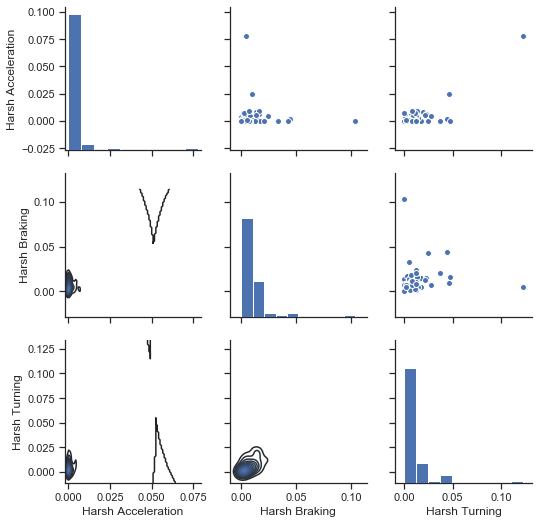

In [16]:
import seaborn as sns
sns.set(style="ticks",font_scale=1.00)
g = sns.PairGrid(features)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot,n_levels=15)

All features are skewed to the right with a long tail. On the diagnoal, we see a histogram of all features. On the upper triangle we see a scatterplot of each pair of features, and on the bottom triangle we see a KDE (Kernel Density Estimation) of each pair of features

### Outliers handling
We wish to remove/adjust outliers as they affect many statistical approaches. In order to remove these, we'll transform the features to normal (using a box-cox transformation) and remove based on *mean + k*std's* rule. A second approach could be to truncate the tail using some constant, but it will be more difficult to find this threshold than the standard deviation rule. A third option is to remove outliers on all three dimensions (using a multivariate normal distribution, for example).

This code performs the first option, box-cox transformation:

x[ 1.1 12.   2.   3.   4.   5.  67.   8.   9.   9.   9.  90.1  1.   2.9]
y[ 1.1 12.   2.   3.   4.   5.  67.   8.   9.   9.   9.   1.   1.   2.9]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


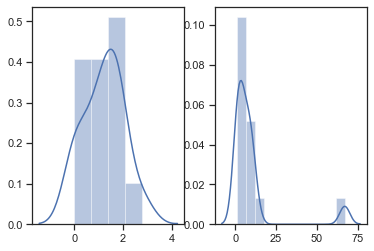

In [17]:
#Box-cox transformation
from scipy.stats import boxcox
from scipy.special import inv_boxcox
x= np.array([1.1,12,2,3,4,5,67,8,9,9,9,90.1,1,2.9])
X,alpha=boxcox(x)
X[11]=0
y=inv_boxcox(X,alpha)
print("x{}\ny{}".format(x,y))

fig, ax =plt.subplots(1,2)
sns.distplot(X, ax=ax[0])
sns.distplot(y, ax=ax[1])
fig.show()

In [18]:
import scipy.stats as st

def transform_to_normal(x,min_max_transform = False):
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    valueGreaterThanZero = np.where(x<=0,0,1)
    positives = x[valueGreaterThanZero == 1]
    
    if(len(positives)> 0):
        xt[valueGreaterThanZero == 1],_ = st.boxcox(positives+1)
    if min_max_transform:
        xt = (xt - np.min(xt)) / (np.max(xt)-np.min(xt))
    return xt

transFeatures = features.apply(lambda x: (transform_to_normal(x,min_max_transform =True)))
transFeatures.head()

,Harsh Acceleration,Harsh Braking,Harsh Turning
DriverId,,,
0,0.0386,0.5650,0.3484
1,0.0337,0.1329,0.0000
2,0.4766,0.5569,0.2748
4,0.0000,0.7523,0.8953
5,0.1601,0.2851,0.6641


### Scatter plot matrix of transformed features

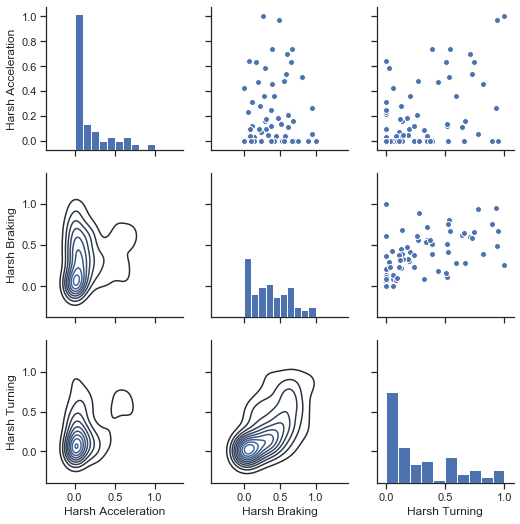

In [19]:
g = sns.PairGrid(transFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")

You can see that the distribution is not symmetric yet, but not as skewed as the original data.
Let's use the mean + k std rule:

In [20]:
### remove outliers
import seaborn as sns
sns.set(style="ticks")

def replace_outliers_with_limit(x, stdFactor = 2.5, normalize = False):
    print(x.name)
    x = x.values
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    xt = transform_to_normal(x)

    xMean, xStd = np.mean(xt), np.std(xt)
    outliers = np.where(xt > xMean + stdFactor*xStd)[0]
    inliers = np.where(xt <= xMean + stdFactor*xStd)[0]
    if len(outliers) > 0:
        print("found outlier with factor: "+str(stdFactor)+" : "+str(outliers))
        xinline = x[inliers]
        maxInRange = np.max(xinline)
        print("replacing outliers {} with max={}".format(outliers,maxInRange))
        vals = x.copy()
        vals[outliers] = maxInRange
        x= pd.Series(vals)
    else:
        print("No outliers found")
    if normalize:
        #Normalize to [0,1]
        x = (x - np.min(x)) / (np.max(x)-np.min(x))
    return x

cleanFeatures = features.apply(lambda x: (replace_outliers_with_limit(x,normalize=True)))
cleanFeatures.head(6)

Harsh Acceleration
found outlier with factor: 2.5 : [15 44]
replacing outliers [15 44] with max=0.009031595984491887
Harsh Acceleration
found outlier with factor: 2.5 : [15 44]
replacing outliers [15 44] with max=0.009031595984491887
Harsh Braking
No outliers found
Harsh Turning
No outliers found


,Harsh Acceleration,Harsh Braking,Harsh Turning
0,0.0294,0.1183,0.0564
1,0.0256,0.0202,0.0000
2,0.4854,0.1156,0.0423
3,0.0000,0.1989,0.3008
4,0.1306,0.0475,0.1443
5,0.0871,0.1369,0.1347


Outliers are found only on the harsh acceleration column

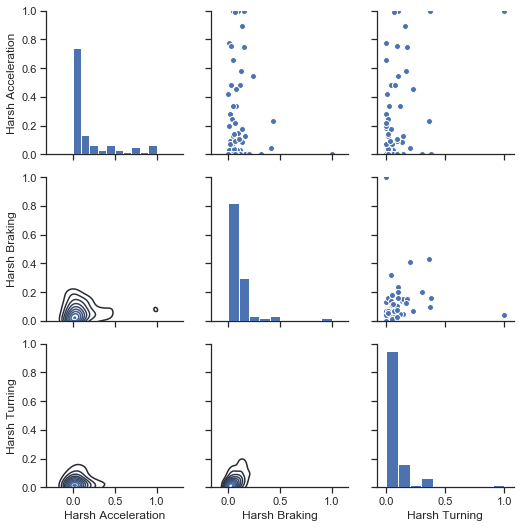

In [21]:
g = sns.PairGrid(cleanFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.set(ylim=((cleanFeatures.min().min()),(cleanFeatures.max().max())))

## Correlations between events

,Harsh Acceleration,Harsh Braking,Harsh Turning
Harsh Acceleration,1.0000,-0.0137,0.4447
Harsh Braking,-0.0137,1.0000,0.1660
Harsh Turning,0.4447,0.1660,1.0000


<Figure size 432x288 with 0 Axes>

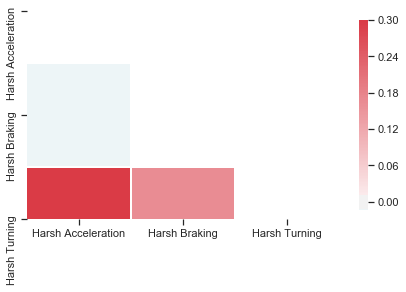

In [22]:
corr = cleanFeatures.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr

## Modeling
#### Main hypothesis

Our main assumption while analyzing this data was that the more events a driver had, the more likely he/she was to be an unsafe driver. A driver with zero harsh turns, zero harsh accelerations, zero over speeding and zero harsh braking over some distance, was more likely to be classified as a safe driver. On the contrary, we can assume that a driver who made multiple harsh movements over the same distance was an unsafe driver.
Modeling approaches

We used a number of different approaches for modeling:

- Modeling the problem as an anomaly detection problem or using some sort of clustering to find clusters of safe/unsafe drivers.
- Finding a multivariate metric that encompasses our assumption in multi dimensions and allowed us to estimate unsafe driving using probabilities over this multivariate distribution.
- Reducing the dimension to 1 and trying to find a rule/rank on this one unified metric.
    Using a univariate statistical model: modeling each event type individually by using statistical distributions.

In the following section we discuss how we evaluated different approaches for modeling this data.

In [71]:
## Pre step: Normalize features
minPerFeature = cleanFeatures.min()
maxPerFeature = cleanFeatures.max()

print("Min and Max values per column before normalization")
for col in range(0,len(cleanFeatures.columns)):
    print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))

normalizedFeatures = (cleanFeatures-cleanFeatures.min())/(cleanFeatures.max()-cleanFeatures.min())
normalizedFeatures.head()

## Standardize features after box-cox as well.
transFeaturesScaled = (transFeatures - transFeatures.mean())/transFeatures.std()
print("")
print("Mean and STD before standardization")
for col in range(0,len(transFeatures.columns)):
    print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


normalizedFeatures.head()

Min and Max values per column before normalization
Harsh Acceleration range:[0.0,0.009031595984491887]
Harsh Braking range:[0.0,0.10340548522686539]
Harsh Turning range:[0.0,0.12259498755008752]

Mean and STD before standardization
Harsh Acceleration range:[0.18775905276289825,0.25588420026047654]
Harsh Braking range:[0.3556351512504195,0.276056089678018]
Harsh Turning range:[0.2865774139188881,0.29888576889340224]


,Harsh Acceleration,Harsh Braking,Harsh Turning
0,0.0294,0.1183,0.0564
1,0.0256,0.0202,0.0000
2,0.4854,0.1156,0.0423
3,0.0000,0.1989,0.3008
4,0.1306,0.0475,0.1443


### Anomaly detection:

The first approach we used was anomaly detection. We tried to see if we could highlight meaningful anomalies that might contain information about driver safety. A few approaches were evaluated, among them a method called HBOS and Local Outlier Factor (LOF). This plot shows the output of LOF on two dimensions of the dataset:

In [72]:
## LOF - Local Outlier Filter
from sklearn.neighbors import LocalOutlierFactor

X = transFeaturesScaled.values

clf = LocalOutlierFactor(n_neighbors=5)
isOutlier = clf.fit_predict(X)

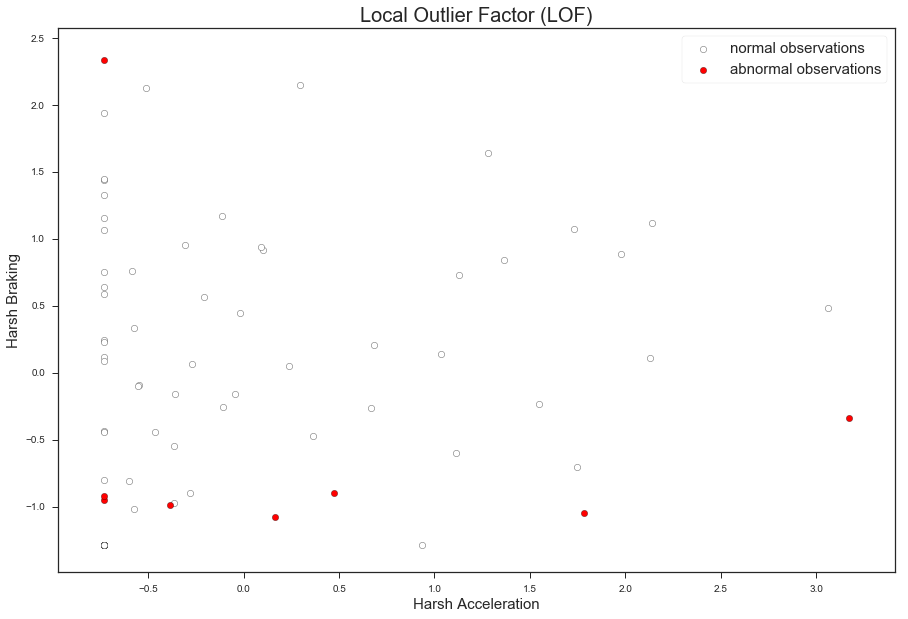

In [73]:
plt.title("Local Outlier Factor (LOF)",fontsize=20)


a = plt.scatter(X[isOutlier==1, 0], X[isOutlier==1, 1], c='white',
                edgecolor='k', s=40)
b = plt.scatter(X[isOutlier==-1, 0], X[isOutlier==-1, 1], c='red',
                edgecolor='k', s=40)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.xlabel(normalizedFeatures.columns[0],fontsize = 15)
plt.ylabel(normalizedFeatures.columns[1],fontsize = 15)
#plt.xlim((-0.01,1.01))
#plt.ylim((-0.01, 1.01))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper right",prop={'size': 15},frameon = True)
plt.show()

The LOF model looks for anomalous points in respect to each point's neighborhood. We ran LOF on all three dimensions, however this plot shows only the first two dimensions. Even after playing with the model's parameter (number of neighbors), we did not achieve meaningful results. It appears that statistical outliers did not imply behavioral outliers in this case.
### Multivariate analysis

The second approach was to find a multivariate representation of the distribution and then use it to calculate the probability of one driver being unsafe when compared to a general population of drivers. This link describes some of the methods around multivariate density estimation. Essentially we look for drivers that lay on the tail of a multivariate right skewed distribution. We didn't pursue with this approach since most methods assume normal distribution, have other unmet assumptions, or do not have a robust implementation we could employ.
### Dimensionality reduction

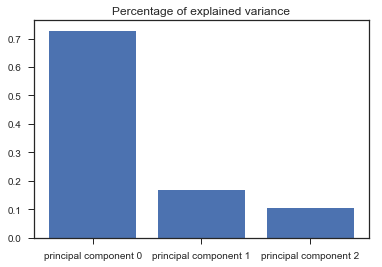

Pricipal components explained variance ratio: [0.7275472  0.16648689 0.10596592].


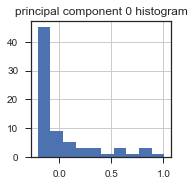

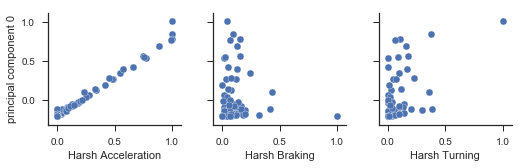

In [131]:
### PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

principalComponents = pca.fit_transform(normalizedFeatures)
column_names = ['principal component {}'.format(i) for i in range(normalizedFeatures.shape[1])]


plt.bar(x = column_names,height = pca.explained_variance_ratio_)
plt.title("Percentage of explained variance")
plt.show()

print("Pricipal components explained variance ratio: {}.".format(pca.explained_variance_ratio_))


principalDf = pd.DataFrame(data = principalComponents
             , columns = column_names)

import matplotlib.pyplot as plt
df = normalizedFeatures
fig = plt.gcf()
fig.set_size_inches(15,10)


## Show correlation matrix of the original features and the first principal component
pcAndOriginal = pd.concat([principalDf.iloc[:,0].reset_index(drop=True), normalizedFeatures], axis=1)
sns.set(style="ticks")
histplot = pcAndOriginal['principal component 0'].hist(figsize = (2.5,2.5))
histplot.set_title("principal component 0 histogram")
sns.pairplot(pcAndOriginal,y_vars=['principal component 0'],
                  x_vars=['Harsh Acceleration', 'Harsh Braking', 'Harsh Turning'])


The first principal component was the only one that preserved the order of the data (has positive correlation with all original features). However, since this component only explained ~70% of the variance, it was not accurate enough to be used as a metric for ranking.


### The selected model: comparing each driver to a homogeneous population

In the end, we decided to use the technique of modeling the distribution of each event, and then evaluating each individual car by comparing it to general data from the overall homogeneous population. Since all events had a skewed distribution, we decided to use an exponential or gamma distribution. In this approach, instead of using a multivariate model that might be difficult to explain, we used a weighted sum of probabilities. For each event distribution, we estimated the Cumulative Distribution Function (CDF) value, and performed a weighted sum across all event types.

Additionally, it is possible to evaluate the goodness-of-fit or the SSE measure between the data and the proposed distribution, to detect drifts or changes in the data that might affect the model once it is finally deployed to production.

#### Extract statistics from the fitted distributions

In [133]:
import scipy.stats as st


def fit_distribution_params(series):
    print("Extracting distribution parameters for feature: " + series.name + " (" + str(len(series)) + ' values)')
    xPositive = series[series>0]
  
    probs = np.zeros(len(series))
    if(len(xPositive)>0):
        params = st.expon.fit(xPositive)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        #print('params = {}, {}, {}.'.format(arg,loc,scale))
        return arg, loc, scale

def calculate_score_for_series(x, fittedParams,verbose = False):
    
    print("Calculating scores for feature: "+ x.name)
    xPositive = x[x>0]
  
    probs = np.zeros(len(x))
    if(len(xPositive)>0):
        arg = fittedParams[x.name]['arg']
        loc = fittedParams[x.name]['loc']
        scale = fittedParams[x.name]['scale']
        probs[x>0] = st.expon.cdf(xPositive, loc=loc, scale=scale, *arg)
        if verbose:
            probs_df = pd.DataFrame({'Event value':x.values.tolist(),'Event probability':probs},index = None)
            probs_df = probs_df.sort_values(by = 'Event value')
            print(probs_df)
    return probs

## Store each fitted distribution parameters for later use
fittedParams = {}
for col in normalizedFeatures.columns:
    arg,loc,scale = fit_distribution_params(normalizedFeatures[col])
    fittedParams[col] = {}
    fittedParams[col]['arg'] = arg
    fittedParams[col]['loc'] = loc
    fittedParams[col]['scale'] = scale
import json
print('Fitted parameters:')
print(json.dumps(fittedParams, indent=2))

##Commulative distribution/density function
perFeatureScores = normalizedFeatures.apply(calculate_score_for_series,args=(fittedParams,False),axis=0).add_suffix("_CDF")

perFeatureScores.head()

Extracting distribution parameters for feature: Harsh Acceleration (74 values)
Extracting distribution parameters for feature: Harsh Braking (74 values)
Extracting distribution parameters for feature: Harsh Turning (74 values)
Fitted parameters:
{
  "Harsh Acceleration": {
    "arg": [],
    "loc": 0.02564752667369235,
    "scale": 0.3035523938874951
  },
  "Harsh Braking": {
    "arg": [],
    "loc": 0.008563681894357935,
    "scale": 0.10105576180418932
  },
  "Harsh Turning": {
    "arg": [],
    "loc": 0.0037259420919605983,
    "scale": 0.09982577201370954
  }
}
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Braking
Calculating scores for feature: Harsh Turning


,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turning_CDF
0,0.0124,0.6623,0.4099
1,0.0000,0.1084,0.0000
2,0.7801,0.6533,0.3203
3,0.0000,0.8480,0.9490
4,0.2923,0.3199,0.7554


Harsh Acceleration
sse: 88.81292779966475
Harsh Braking
sse: 24.760400326313338
Harsh Turning
sse: 98.53717270817495


Text(0,0.5,'Number of drivers')

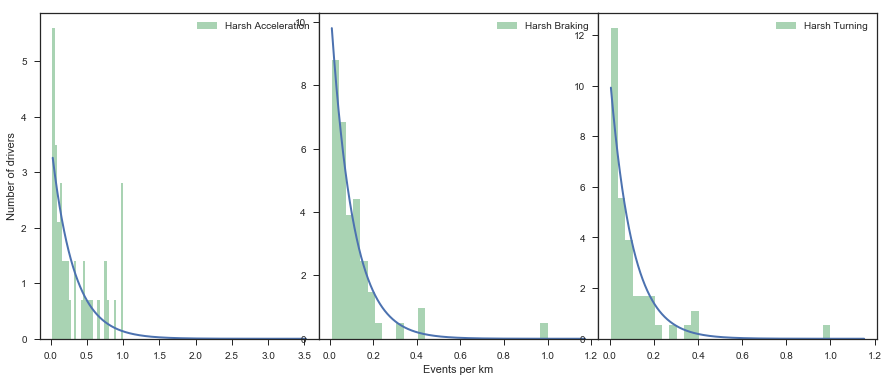

In [134]:
## Plot each fitted distribution

import matplotlib.pyplot as plt
import scipy.stats as st

DIST = st.expon

def create_pdf(dist, params, size=10000):

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99999, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## fit exponential distribution
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for col in normalizedFeatures:
    print(col)
    feature = normalizedFeatures[col]
    x = feature.values[feature.values > 0] # only fit positive values to keep the distribution tighter
   
    params = DIST.fit(x)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
   
    #Plot
    pdfForPlot = create_pdf(DIST,params)
    pdfForPlot.plot(lw=2, label='PDF',ax=axs[i])
    
    #Plot
    feature[feature.values >0].plot(kind='hist', bins=30, density=True, alpha=0.5, label=feature.name, legend=True,ax=axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    ## Calculate SSE
    yhist, xhist = np.histogram(x, bins=60, density=True)
    xhist = (xhist + np.roll(xhist, -1))[:-1] / 2.0
    histPdf = DIST.pdf(xhist, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(yhist - histPdf, 2.0))
    print("sse:",sse)
    i+=1
axs[1].set_xlabel('Events per km')
axs[0].set_ylabel('Number of drivers')

    

#### Create a single metric
The commulative metric is the sum (or weighted sum) of CDFs per event type. here we assume that features have equal weights.

In [77]:
def calculate_joint_score(perFeatureScores):
    driverScores = perFeatureScores
    featureCols = [col for col in driverScores if col.startswith('Harsh')]
    driverScores['metric'] = (driverScores[featureCols].sum(axis = 1) / 3.0)
    driverScores = driverScores.sort_values('metric')
    driverScores['rank'] = (driverScores.metric.rank(method="min")-1)/((len(perFeatureScores)-1)*1.0)
    return driverScores

driverScores = calculate_joint_score(perFeatureScores)

Since the entire population won't be available on test time, we fit a simple linear model to find the relation between the metric (weighted sum of CDFs) and the rank (the position in the population). We will use the metric value at test time, and this model to estimate the driver's hypothetical rank in this population. Since we are doing in-population analysis, and this is a very simple model, there's no need for train/test split.

In [78]:
from sklearn.linear_model import LinearRegression

def get_linear_model(perFeatureScores):
    driverScores = calculate_joint_score(perFeatureScores)
    reg = LinearRegression()
    x = driverScores['metric'].values.reshape(-1, 1)
    y = driverScores['rank'].values.reshape(-1, 1)
    reg.fit(x,y)
    return reg
    

def get_rank(regModel,metric):
    rank = regModel.predict(metric)
    rank = np.asscalar(np.where(rank > 1,1,rank))
    rank = np.asscalar(np.where(rank < 0,0,rank))
    return rank
    
regModel = get_linear_model(perFeatureScores)
sampleRank = get_rank(regModel,0.5)
sampleRank

0.6946498430580719

In [79]:
## Top 10 safest drivers?
driverScores.head(10)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turning_CDF,metric,rank
32,0.0000,0.0000,0.0000,0.0000,0.0000
29,0.0000,0.0000,0.0000,0.0000,0.0000
70,0.0000,0.0000,0.0000,0.0000,0.0000
68,0.0000,0.0000,0.0000,0.0000,0.0000
67,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000
27,0.0000,0.0000,0.0000,0.0000,0.0000
25,0.0000,0.0000,0.0000,0.0000,0.0000
51,0.0000,0.0000,0.0000,0.0000,0.0000
20,0.0000,0.0000,0.0000,0.0000,0.0000


In [80]:
## top 10 most risky drivers?
driverScores.tail(10)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turning_CDF,metric,rank
39,0.0598,0.9813,0.8590,0.6334,0.8767
59,0.7543,0.4610,0.8924,0.7026,0.8904
44,0.9596,0.2898,1.0000,0.7498,0.9041
42,0.8187,0.8948,0.6243,0.7793,0.9178
72,0.8374,0.6871,0.8154,0.7800,0.9315
48,0.9596,0.7658,0.6326,0.7860,0.9452
7,0.9421,0.7005,0.7953,0.8127,0.9589
37,0.4887,0.9844,0.9724,0.8152,0.9726
16,0.9075,0.7541,0.8275,0.8297,0.9863
15,0.9596,0.5761,0.9755,0.8371,1.0000


## Distributions of CDFs, rank and metric values

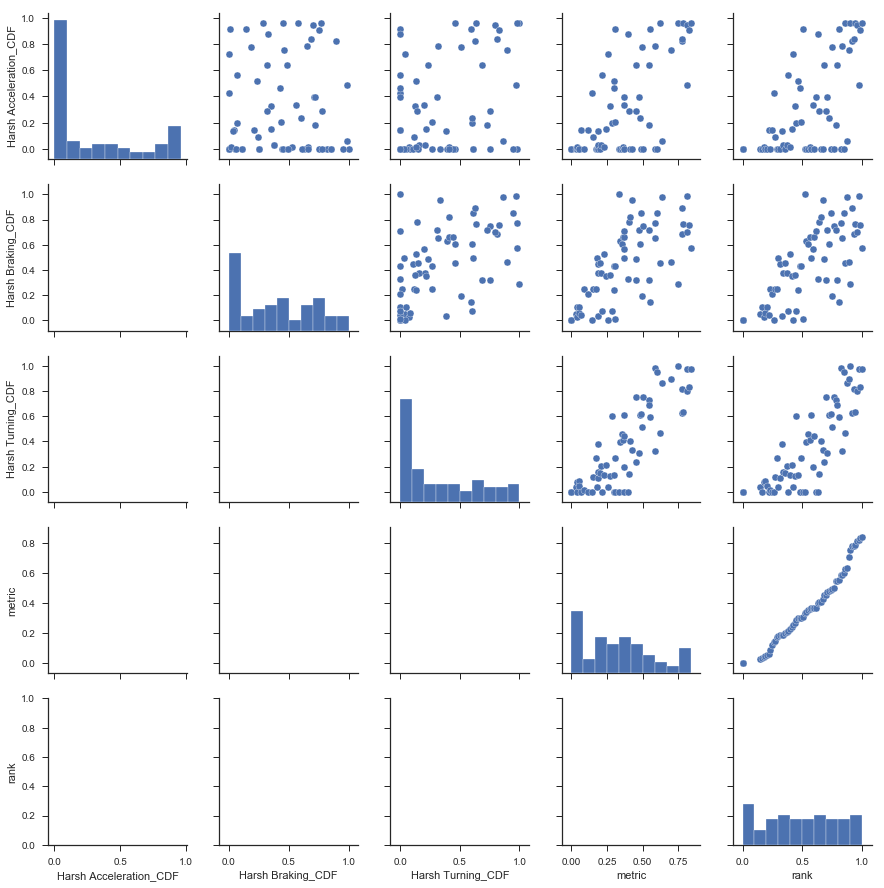

In [81]:
import seaborn as sns
sns.set(style="ticks")
g = sns.PairGrid(driverScores)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_diag(plt.hist, edgecolor="w")

### Estimating safety for an arbitrary subscriber
The following process estimates the score of a new driver:
1. Calculate features - number of events per km
2. Calculate CDFs by estimating the CDF per feature value using the fitted functions during 'training'. We use the function's parameters to estimate the CDF per new value.
3. Calculate the weighted sum metric. The value of this metric corresponds to the point in the population this new driver resides in.
4. Calculate a rank within a population

In [89]:
safeDriver = [{'Harsh Acceleration':0.005,
                       'Harsh Braking':0.005,
                       'Harsh Turning':0.005}]

riskyDriver = [{'Harsh Acceleration':0.2,
                       'Harsh Braking':0.16,
                       'Harsh Turning':0.28}]

safeDriverDf = pd.DataFrame(safeDriver,index = None)
riskyDriverDf = pd.DataFrame(riskyDriver,index = None)

print('****** Estimated safety scores ******')
def get_score_one_driver(driverDf,fittedParams,minPerFeature,maxPerFeature):

    normalized = (driverDf - minPerFeature) / (maxPerFeature - minPerFeature)
    scoreDF = pd.DataFrame()
    for col in normalized:
        scoreDF[col] = calculate_score_for_series(normalized[col],fittedParams,True)
    scoreDF = calculate_joint_score(scoreDF)
    return scoreDF


safeDriverWithMetric = get_score_one_driver(safeDriverDf, fittedParams,minPerFeature,maxPerFeature)
riskyDriverWithMetric = get_score_one_driver(riskyDriverDf, fittedParams,minPerFeature,maxPerFeature)

safeDriverMetric = safeDriverWithMetric['metric'].values[0]
riskyDriverMetric = riskyDriverWithMetric['metric'].values[0]


print('------')
print("Rank for safe driver = {}".format(get_rank(regModel,safeDriverMetric)))
print("Metric for safe driver = {}".format(safeDriverMetric))
print('------')
print("Rank for risky driver = {}".format(get_rank(regModel,riskyDriverMetric)))
print("Metric for risky driver = {}".format(riskyDriverMetric))


****** Estimated safety scores ******
Calculating scores for feature: Harsh Acceleration
   Event probability  Event value
0             0.8244       0.5536
Calculating scores for feature: Harsh Braking
   Event probability  Event value
0             0.3255       0.0484
Calculating scores for feature: Harsh Turning
   Event probability  Event value
0             0.3101       0.0408
Calculating scores for feature: Harsh Acceleration
   Event probability  Event value
0             1.0000      22.1445
Calculating scores for feature: Harsh Braking
   Event probability  Event value
0             1.0000       1.5473
Calculating scores for feature: Harsh Turning
   Event probability  Event value
0             1.0000       2.2839
------
Rank for safe driver = 0.6785927595653235
Metric for safe driver = 0.486647447960139
------
Rank for risky driver = 1.0
Metric for risky driver = 0.9999999186733707


There are two alternatives here for results: the metric (weighted sum), which gives a score with regards to the amount of events of each type, and the rank, which shows on which percentile of the population the driver is. Depending on the use case, one can decide on the right metric.
Since the relation between these two metrics is not 100% linear, we get different results than the training set. In this case we get a rank of 0.28 and metric of 0.15 for a driver with almost 0 events.

# Deployment on a Spark cluster
The PySpark code is very similar to the pandas code. It performs the feature calculation and normalization on a spark cluster, where each car/driver's data is computed separately. Then it aggregates the data into one node and performs the population statistics on this node. This process is run for each segment in the population, where segments are groups of drivers with similar attributes (e.g. same type of vehicle, same country, same device installed, same device firmware/software).

For the PySpark version of this analysis, open [this notebook](Driver safety estimation - pyspark.ipynb)